# Notebook for subtask-A of phase one

## Fitting a model to each individual station

Here we don't construct an ensemble, with the use case of predicting for the same stations in future

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

from natsort import natsorted

# Define some functions

- replace_nan fills NaN values with column means. We don't use it but it was useful for exploratory analysis
- show_nans is also for exploration
- convert_weekdays moves weekday strings into integers from one to seven
- score_abs_error takes a model with SKLEARN syntax and used it to predict the number of bikes based on input data, then return the mean absolute error. round_ specifies whether output should be rounded to integers.
- reasonable_predictions is a bit redundant, taking a model and data and predicting


In [2]:
def replace_nan(df):
    nan_cols = df[df.columns[df.isnull().any()]].columns
    nan_cols = nan_cols.drop('bikes')
    df[nan_cols] = df[nan_cols].fillna(value=df[nan_cols].mean())

    
def show_nans(df):
    n_stations = np.unique(df['station'])
    print(f'\nThere are {n_stations} stations')
    print(f'There are {df.shape[0] - df.dropna().shape[0]} rows containing missing data\n')

    

# converting weekdays into integers [1-7]
def convert_weekdays(df):
    df = df.replace(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    [1, 2, 3, 4, 5, 6, 7])
    return df
    
def score_abs_error(model, data, num_docks, round_ = False):
    if round_ == True:
        y_pred = np.around(  model.predict(data.iloc[:,:-1].to_numpy()) * num_docks)
    else:
        y_pred = model.predict(data.iloc[:,:-1].to_numpy())  * num_docks
    y_gold = data["bikes"].to_numpy() * num_docks
    
    return mean_absolute_error(y_gold, y_pred)

def reasonable_predictions(model, data):
    y_pred = model.predict(data.to_numpy())
    return y_pred


The next cell has functions to remove unwanted features, add our new isOff feature. 

It reads all the training files and builds collections of training sets, validation sets, and scalers for each station.

In [3]:
pd.options.mode.chained_assignment = None

def is_hol_weekend(row):
    if row['weekday'] == 6 or row['weekday'] == 7:
        return 1
    if row['isHoliday'] == 1:
        return 1
    if row['hour'] > 17 or row['hour'] < 9:
        return 1
    return 0

def generate_dataframe(dataframe):
    dataframe = convert_weekdays(dataframe)
    
    # # deleting unneeded columns
    del dataframe["month"]
    del dataframe["year"]
    # del df["timestamp"]
    del dataframe["station"]
    del dataframe["precipitation.l.m2"]
    
    del dataframe["latitude"]
    del dataframe["longitude"]
    
    
    default_columns = list(dataframe.columns)
    
    dataframe['isOff'] = dataframe.apply(is_hol_weekend,axis=1)
    
    default_columns = ["isOff"] + default_columns
    
    dataframe = dataframe[default_columns]
    
    print(dataframe.columns)
    
    del dataframe['isHoliday']
    #del dataframe["timestamp"]
    
    
    columns = list(dataframe.columns[-6:])
    
    if "bikes" in columns:
        pass
    else:
        columns = columns[1:]
    
    print(columns)
    for c in columns:
        dataframe[c] = dataframe[c].to_numpy() / dataframe["numDocks"].to_numpy()
    num_docks = dataframe["numDocks"]
    
    del dataframe["numDocks"]
    
    return dataframe, num_docks

def vectorise_dataframe(dataframe):
    
    # # deleting unneeded columns
    del dataframe["month"]
    del dataframe["year"]
    #del dataframe["timestamp"]
    del dataframe["station"]
    del dataframe["precipitation.l.m2"]
    #del dataframe["weekhour"]
    
    del dataframe["latitude"]
    del dataframe["longitude"]
    
    
    
    default_columns = list(dataframe.columns)
    dataframe['isOff'] = dataframe.apply(is_hol_weekend,axis=1)

    
    default_columns = ["isOff"] + default_columns
    default_columns.remove('weekday')

    dataframe = dataframe[default_columns]

    del dataframe['isHoliday']

    columns = list(dataframe.columns[-6:])
    
    if "bikes" in columns:
        pass
    else:
        columns = columns[1:]

    for c in columns:
        dataframe[c] = dataframe[c].to_numpy() / dataframe["numDocks"].to_numpy()
    num_docks = dataframe["numDocks"].to_numpy()

    
    del dataframe["numDocks"]

    
    
    return dataframe, num_docks

# Adding all files into one DataFrame
trains = []
vals = []

train_docks_list = []
val_docks_list = []

scalers = []



paths = []
for i, path in enumerate(Path('./Train/Train').rglob('*.csv')):
    paths.append(path)


paths = [Path(p) for p in natsorted([str(p) for p in paths ])]


for i, path in enumerate(paths):
    tmp = pd.read_csv(path)

    tmp = tmp.dropna(axis='rows')


    #if i  not in  val_inds:
    train, val = train_test_split(tmp, test_size=0.2)


    train, train_docks = vectorise_dataframe(train)
    val, val_docks = vectorise_dataframe(val)

    scaler = RobustScaler()

    train[train.columns[:-1]] = scaler.fit_transform(train[train.columns[:-1]])
    val[val.columns[:-1]] = scaler.transform(val[val.columns[:-1]])

    trains.append(train)
    vals.append(val)

    train_docks_list.append(train_docks)
    val_docks_list.append(val_docks)

    scalers.append(scaler)

    del tmp




In [4]:
trains[0]

,isOff,timestamp,day,hour,weekhour,windMaxSpeed.m.s,windMeanSpeed.m.s,windDirection.grades,temperature.C,relHumidity.HR,airPressure.mb,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,short_profile_3h_diff_bikes,short_profile_bikes,bikes
436,0.0,-0.059965,0.000000,-0.666667,0.876712,-0.858407,-0.533333,-0.386579,-0.696774,0.730769,0.444444,-0.4,-1.846154,0.375000,-1.846154,0.375000,0.074074
407,0.0,-0.162257,-0.170213,0.916667,0.479452,0.283186,0.800000,-1.290508,0.025806,0.769231,0.170213,-0.2,0.923077,1.250000,0.923077,1.250000,0.629630
616,-1.0,0.574956,0.595745,0.250000,1.027397,0.566372,0.800000,-1.806711,0.464516,-0.038462,0.330969,0.8,0.538462,0.416667,0.538462,0.416667,0.185185
214,0.0,-0.843034,-0.851064,0.833333,0.136986,-0.292035,-0.266667,0.000000,0.670968,0.307692,-0.737589,0.8,-0.692308,-0.500000,-0.692308,-0.500000,0.148148
385,0.0,-0.239859,-0.170213,-0.916667,0.178082,-0.150442,-0.266667,1.032406,0.258065,-0.230769,-0.302600,0.0,-0.461538,-0.625000,-0.461538,-0.625000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,0.0,-0.225750,-0.170213,-0.583333,0.232877,0.283186,0.533333,0.516203,-0.154839,-0.115385,-0.293144,-0.6,0.115385,-0.500000,0.115385,-0.500000,0.000000
526,0.0,0.257496,0.255319,0.833333,-0.191781,-0.716814,-0.533333,0.516203,-0.361290,0.115385,0.652482,0.0,0.076923,-0.250000,0.076923,-0.250000,0.037037
718,0.0,0.934744,0.936170,0.750000,0.123288,-0.150442,0.266667,-1.290508,-0.361290,0.730769,0.520095,1.0,-0.461538,-0.187500,-0.461538,-0.187500,0.111111
528,0.0,0.264550,0.340426,-1.000000,-0.164384,-0.433628,-0.266667,-0.258102,-0.903226,0.192308,0.680851,-0.6,0.538462,0.000000,0.538462,0.000000,0.111111


## Fit a model for each station on its training set

In [5]:
from time import time
from tqdm import tqdm
start = time()
print("initialised")

models = []

for i in tqdm(range(len(trains))):
    forest_boost = RandomForestRegressor(n_estimators= 200, max_depth= 5)
    forest_boost.fit(trains[i].iloc[:,:-1].to_numpy(), trains[i]["bikes"].to_numpy())
    
    models.append(forest_boost)
print(f'fitted in {time() - start}s')

initialised


100%|████████████████████████████████████████████| 75/75 [00:15<00:00,  4.96it/s]

fitted in 15.116409063339233s


## Measure each model's performance on its respective validation set

In [11]:
import matplotlib.pyplot as plt

errors = []
rounded_errors = []
y_pred = []
y_gold = []

for i in tqdm(range(len(vals))):
    errors.append(score_abs_error(models[i], vals[i], val_docks_list[i]))
    rounded_errors.append(score_abs_error(models[i], vals[i], val_docks_list[i], round_ = True))
    
    pred = list(models[i].predict(vals[i].iloc[:, :-1].to_numpy()))
    
    y_pred = y_pred + list(pred * val_docks_list[i])
    
    y_gold = y_gold + list(vals[i]["bikes"] * val_docks_list[i]) 
    
print(f'\nNon-rounded mean error: {np.mean(errors)}')
print(f'Rounded mean error: {np.mean(rounded_errors)}\n')



100%|████████████████████████████████████████████| 75/75 [00:01<00:00, 58.77it/s]


Non-rounded mean error: 2.1324484807244146
Rounded mean error: 2.117309941520468



## Plot histograms to compare predictions to the gold values

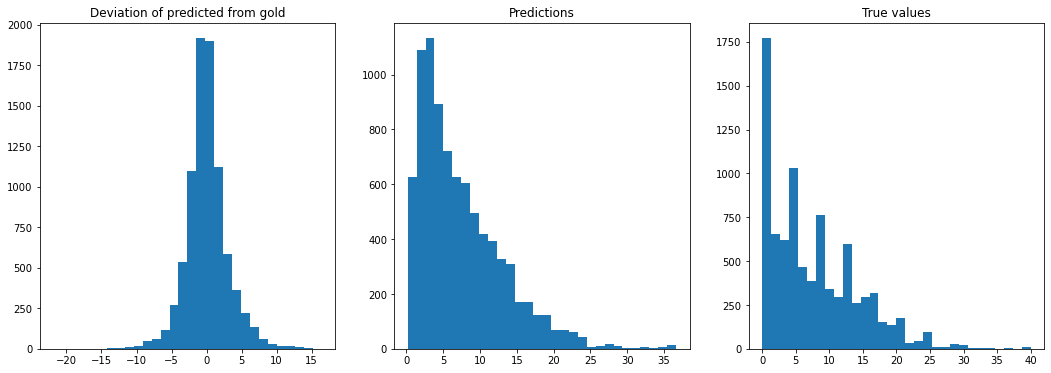

In [12]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(18,6))

ax1.hist(np.array(y_gold) - np.array(y_pred), bins=30)
ax1.set_title("Deviation of predicted from gold")
ax2.hist(np.array(y_pred), bins=30)
ax2.set_title("Predictions")
ax3.hist(np.array(y_gold), bins=30)
ax3.set_title("True values")

plt.show()

## Predict values for the test set on a by-station basis


In [13]:
test = pd.read_csv('test.csv')

ids = test["Id"]

del test["Id"]

stations = np.unique(test["station"])
#print(stations)
y_pred = []

for idx_station, station in enumerate(stations):
    

    test_i, test_docks_i = vectorise_dataframe(test[test["station"] == station])
    
    test_i = scalers[idx_station].transform(test_i)
    model = models[idx_station]
    
    y_pred_i = (model.predict(test_i) * test_docks_i).tolist()

    y_pred = y_pred + y_pred_i

y_pred = np.array(y_pred)
y_pred = np.where(y_pred < 0, 0, y_pred)


sub_df = pd.DataFrame(data=y_pred, index = ids, columns = ["bikes"])

sub_df.index.name = 'Id'

sub_df.to_csv("submission.csv")

 - Score with un-normalised data, scaled by station, RandomForestRegressor(n_estimators= 400, max_depth= 5), was 3.26
 - Score with normalised data, scaled by station, RandomForestRegressor(n_estimators= 200, max_depth= 5), was 3.23